# Обработка текстовых данных

## Вступление
Многие практические задачи так или иначе могут вовлекать в себя работу с текстовыми данными, например:

- классификация текстов
    - анализ тональности (например, позитивный/негативный отзыв)
    - фильтрация спама
    - по теме или жанру
- машинный перевод
- распознавание и синтез речи
- извлечение информации
    - именованные сущности (например, извлечение имен, локаций, названий организаций)
    - извлечение фактов и событий
- кластеризация текстов
- оптическое распознавание символов
- проверка правописания
- вопросно-ответные системы, информационный поиск
- суммаризация текстов
- генерация текстов

В целом, алгоритм работы с текстовыми данными можно разбить на такие шаги:

- предобработка сырых данных
- токенизация (создание словаря)
- обработка словаря (удаление стоп-слов и пунктуации)
- обработка токенов (лемматизация / стемминг)
- векторизация текста (bag of words, TF-IDF, etc)

### Структура ноутбука:
0. Регулярные выражения
1. Токенизация
2. Стоп-слова и пунктуация
3. Лемматизация и стемминг
4. Bag-of-words и TD-IDF
5. Решение задачи с текстовыми данными
6. Немножко про категориальные признаки
7. Полный пошаговый пайплайн работы с текстом

**Для работы с тектом я буду в основном пользоваться библиотекой `nltk` (Natural Language Toolkit) — это популярная и очень мощная библиотека Python для обработки и анализа естественного языка (NLP).**

*Что можно реализовать с помощью nltk:*

- разбиение текста на предложения и слова (токенизация)
- удаление стоп-слов
- стемминг (приведение слова к корню)
- лемматизация (приведение к начальной форме)
- определение частей речи
- обработка синтаксиса и деревьев разбора
- работа с большими текстовыми корпусами (коллекциями текстов)
- построение частотных словарей, анализ n-грамм
- подготовка текста для последующего машинного обучения

In [2]:
#загрузка библиотеки nltk
# !pip install nltk

In [3]:
#загрузка библиотеки nltk
# !pip install pandas

## 0. Регулярные выражения

Часто бывает так, что для конкретного случая нужен особый способ токенизации, и надо самостоятельно написать правило шаблонного типа для определения того, что такое токен. Или, например, перед работой с текстом, надо почистить его от своеобразного мусора: упоминаний пользователей, url и так далее. В таких задачах могут помочь регулярные выражения. Навык полезный, давайте в нём тоже потренируемся.

In [1]:
import re

### findall
возвращает список всех найденных совпадений

- `?` : ноль или одно повторение
- `*` : ноль или более повторений
- `+` : одно или более повторений
- `.`: любой символ

In [2]:
result = re.findall("ab+c.", "abcdefghijkabcabcxabc")
print(result)

['abcd', 'abca']


In [3]:
re.findall("ab+c.", "abbbca")

['abbbca']

### split
разделяет строку по заданному шаблону

In [4]:
result = re.split(",", "itsy, bitsy, teenie, weenie")
print(result)

['itsy', ' bitsy', ' teenie', ' weenie']


In [5]:
result = re.split(",", "itsy, bitsy, teenie, weenie", maxsplit=2)
print(result)

['itsy', ' bitsy', ' teenie, weenie']


### sub
ищет шаблон в строке и заменяет все совпадения на указанную подстроку

параметры: (pattern, repl, string)

In [6]:
result = re.sub("a", "b", "abcabc")
print(result)

bbcbbc


При этом в качестве repl, можно передавать не только строку, но и функцию, которая принимает на вход [Match](https://docs.python.org/3/library/re.html#match-objects) объект. Можно делать что-то типо этого:

In [7]:
counter = 0


def count(match):
    global counter
    counter += 1
    return f"(a#{counter})"


re.sub("a", count, "abcabc")

'(a#1)bc(a#2)bc'

Кстати, c объектами типа re.Match работают и многие другие методы re. Например, метод re.finditer в отличии от re.findall будет возвращать те самые re.Match.

In [8]:
for match in re.finditer("ab+c.", "abcdefghijkabcabcxabc"):
    print(match)

<re.Match object; span=(0, 4), match='abcd'>
<re.Match object; span=(11, 15), match='abca'>


### compile
компилирует регулярное выражение в отдельный объект

In [9]:
# Пример: построение списка всех слов строки:
prog = re.compile("[А-Яа-яё\-]+")
prog.findall("Слова? Да, больше, ещё больше слов! Что-то ещё.")

['Слова', 'Да', 'больше', 'ещё', 'больше', 'слов', 'Что-то', 'ещё']

In [10]:
#Так можно вернуть списко всех доменов из строки с разынми почтами
emails = "abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz"
domains = re.compile(r'@[\w.-]+')
domains.findall(emails)

['@gmail.com', '@test.in', '@analyticsvidhya.com', '@rest.biz']

## 1. Токенизация

Токенизировать — значит, поделить текст на отдельные смысловые единицы (как правило слова, но не обязательно), или по другому *токены*. Самый тривиальный способ токенизировать текст — разделить на слова по пробелам с помощью `split`. Но `split` упускает очень много всего, например, не отделяет пунктуацию от слов. Кроме этого есть ещё много менее очевидных проблем, возникающих при такой токенизации, поэтому на практике всегда используют готовые токенизаторы.

**PS.**
К сожалению, на рабочих устройствах невозможно полностью воспользоваться функционалом бибилиотеки nltk, так как установить саму бибилиотеку можно, а дополнительные зависимости, необходимые для полноценного функционирования, - НЕТ. 

Изначально ноутбук был составлен именно с использованием библиотеки nltk, но при тесте его на рабочем устройстве я убедился что в таком виде он будет не пригоде для использования в работе. Поэтому я принял решение расширить изначальную версию ноутбука разделами и примерами того, как можно заменить некоторые компоненты библиотеки nltk самописными функциями или другими библиотеками. 

Итоговый пайплайн из пункта 8 будет реализован без использования библиотеки nltk.

In [18]:
import warnings

import nltk
import pandas as pd
from nltk.tokenize import word_tokenize

warnings.filterwarnings("ignore")

In [5]:
nltk.download("punkt_tab", quiet=True)

True

In [16]:
example = "Но не каждый хочет что-то исправлять:("

In [7]:
print('Исходный текст:', example)
print('Токенизация c помощью split():', example.split())
print('Токенизация c помощью готового токенизатора:', word_tokenize(example))

Исходный текст: Но не каждый хочет что-то исправлять:(
Токенизация c помощью split(): ['Но', 'не', 'каждый', 'хочет', 'что-то', 'исправлять:(']
Токенизация c помощью готового токенизатора: ['Но', 'не', 'каждый', 'хочет', 'что-то', 'исправлять', ':', '(']


В `nltk` есть много разных токенизаторов, посмотреть на них можно так:

In [8]:
from nltk import tokenize

print('Всего встроенных в nltk токенизаторов:', len(dir(tokenize)))
#первые 10
dir(tokenize)[:10]

Всего встроенных в nltk токенизаторов: 61


['BlanklineTokenizer',
 'LegalitySyllableTokenizer',
 'LineTokenizer',
 'MWETokenizer',
 'NLTKWordTokenizer',
 'PunktSentenceTokenizer',
 'PunktTokenizer',
 'RegexpTokenizer',
 'ReppTokenizer',
 'SExprTokenizer']

Можно получить индексы начала и конца каждого токена:

In [9]:
wh_tok = tokenize.WhitespaceTokenizer()
list(wh_tok.span_tokenize(example))

[(0, 2), (3, 5), (6, 12), (13, 18), (19, 25), (26, 38)]

Некторые токенизаторы ведут себя специфично:

In [10]:
tokenize.TreebankWordTokenizer().tokenize("don't stop me")

['do', "n't", 'stop', 'me']

Для некоторых задач это может быть полезно.

А некоторые предназначены вообще не для текста на естественном языке:

In [11]:
tokenize.SExprTokenizer().tokenize("(a (b c)) d e (f)")

['(a (b c))', 'd', 'e', '(f)']

Есть токенизатор, который может быть полезен для работы с твитами или сообщениями из соц. сетей. Он сохранит смайлики, хештеги и т.п.

In [12]:
from nltk.tokenize import TweetTokenizer

tw = TweetTokenizer()
tw.tokenize(example)

['Но', 'не', 'каждый', 'хочет', 'что-то', 'исправлять', ':(']

### Токенизация с помощью регулярных выражений

В этом разделе приведу 5 примеров написания токенизатора от самого базового (с помощью `split` по пробелам) до более продвинутого, который распознает ссылки, числа с плавающей точкой, эмодзи и дефисные слова.

In [23]:
import re #библиотека для работы с регулярными выражениями, установлена по умолчанию

**1. Токенизация по пробелу**

Пояснение: Разбивает строку по пробелам. Знаки препинания остаются с токенами.

In [24]:
def tokenize_simple(text):
    return text.split()

tokenize_simple(example)

['Но', 'не', 'каждый', 'хочет', 'что-то', 'исправлять:(']

**2. Только слова (токенизация без знаков препинания)**

Пояснение: Извлекает только слова (`w+`), пропуская знаки препинания.

In [26]:
def tokenize_words(text):
    return re.findall(r'\w+', text, re.UNICODE)

tokenize_words(example)

['Но', 'не', 'каждый', 'хочет', 'что', 'то', 'исправлять']

**3. Слова, числа и знаки препинания как отдельные токены**

Пояснение:  
- `\w+` — слова или числа  
- `[^\w\s]` — одиночные знаки препинания  
- Разделяет, например, "привет!" → ["привет", "!"]

In [27]:
def tokenize_words_punct(text):
    return re.findall(r'\w+|[^\w\s]', text, re.UNICODE)

tokenize_words_punct(example)

['Но', 'не', 'каждый', 'хочет', 'что', '-', 'то', 'исправлять', ':', '(']

**4. Учет cлова с дефисом или апострофом, числа, знаки препинания**

Пояснение:  
- `(?:[-']\w+)*` — позволяет объединять слова с дефисом или апострофом как один токен: 25-летний, rock'n'roll

In [28]:
def tokenize_hyphenated(text):
    pattern = r"\w+(?:[-']\w+)*|[^\w\s]"
    return re.findall(pattern, text, re.UNICODE)

tokenize_hyphenated(example)

['Но', 'не', 'каждый', 'хочет', 'что-то', 'исправлять', ':', '(']

**5. Продвинутый вариант: эмодзи, email, url, числа (с разделителем), слова, знаки**

Пояснение:  
- Ищет URL, E-mail, числа, дефисные слова, эмодзи, отдельно знаки препинания.
- Учитывает сложные случаи и современные особенности текстов.

In [ ]:
def tokenize_advanced(text):
    pattern = ( 
    r"(?:https?://\S+)|"       # URL
    r"(?:\w+@\w+\.\w+)|"       # Email
    r"(?:\d{1,3}(?:[.,]\d{3})*(?:[.,]\d+)?)|"  # числа
    r"(?:[a-zA-Zа-яА-ЯёЁ0-9]+(?:[-'][a-zA-Zа-яА-ЯёЁ0-9]+)*)|"
    r"(?:[\U0001F600-\U0001F64F])|"    # эмодзи из диапазона Unicode
    r"[^\w\s]"                      # знаки препинания
)
    
    return re.findall(pattern, text, re.UNICODE)

tokenize_advanced(example)

['Но', 'не', 'каждый', 'хочет', 'что-то', 'исправлять', ':', '(']

**6. Сравнение всех версий токенизаторов**

In [46]:
texts = [
r"Привет! Это тестовое сообщение. Мой e-mail: user@mail.ru",
r"На сайте https://example.com есть топ-5 'best-of-the-best' товаров – 12,5 тысяч отзывов!",
r"Сегодня я :), а вчера был :( и даже ¯\\_(ツ)_/¯",
r"Цена: 1.250,35 руб. Купи сейчас! #выгодно",
r"Слово с дефисом – по-русски, and with-hyphen in English. Don't stop!"
]

In [51]:
for func in [tokenize_simple, tokenize_words, tokenize_words_punct, tokenize_hyphenated, tokenize_advanced]:
    print('Токенизатор:', func.__name__,)
    for t in texts:
        print( 'Исходный текст:', t)
        print('Список токенов:', func(t))
    print('\n')

Токенизатор: tokenize_simple
Исходный текст: Привет! Это тестовое сообщение. Мой e-mail: user@mail.ru
Список токенов: ['Привет!', 'Это', 'тестовое', 'сообщение.', 'Мой', 'e-mail:', 'user@mail.ru']
Исходный текст: На сайте https://example.com есть топ-5 'best-of-the-best' товаров – 12,5 тысяч отзывов!
Список токенов: ['На', 'сайте', 'https://example.com', 'есть', 'топ-5', "'best-of-the-best'", 'товаров', '–', '12,5', 'тысяч', 'отзывов!']
Исходный текст: Сегодня я :), а вчера был :( и даже ¯\\_(ツ)_/¯
Список токенов: ['Сегодня', 'я', ':),', 'а', 'вчера', 'был', ':(', 'и', 'даже', '¯\\\\_(ツ)_/¯']
Исходный текст: Цена: 1.250,35 руб. Купи сейчас! #выгодно
Список токенов: ['Цена:', '1.250,35', 'руб.', 'Купи', 'сейчас!', '#выгодно']
Исходный текст: Слово с дефисом – по-русски, and with-hyphen in English. Don't stop!
Список токенов: ['Слово', 'с', 'дефисом', '–', 'по-русски,', 'and', 'with-hyphen', 'in', 'English.', "Don't", 'stop!']


Токенизатор: tokenize_words
Исходный текст: Привет! Это тес

## 2. Стоп-слова и пунктуация

*Стоп-слова* — это слова, которые часто встречаются практически в любом тексте и ничего интересного не говорят о конретном документе, то есть играют роль шума. Поэтому их принято убирать. По той же причине убирают и пунктуацию.

In [13]:
nltk.download("stopwords", quiet=True)

True

In [14]:
from nltk.corpus import stopwords

print(stopwords.words("russian"))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [15]:
print(stopwords.words("english"))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

Так как 3 ячейки выше не запустятся на рабочих устройствах, то я отдельно вынес списки стоп-слов, зашитые в библиотеку nltk, чтобы ими можно было пользоваться

In [16]:
#список русских стоп слов
rus_stop_words_list = ['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его',
                        'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 
                        'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже',
                        'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом',
                        'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их',
                        'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда',  
                        'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 
                        'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об',
                        'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 
                        'разве', 'три', 'эту', 'моя', 'впрочем', 'хорошо', 'свою', 'этой', 'перед', 'иногда', 'лучше', 'чуть', 'том', 'нельзя',
                        'такой', 'им', 'более', 'всегда', 'конечно', 'всю', 'между']
#список английских стоп слов
eng_stop_words_list = ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as',
                        'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd',
                        'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 
                        'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll",
                        'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 
                        'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more',
                        'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only',
                        'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she'd", "she'll", 
                        "she's", 'should', 'shouldn', "shouldn't", "should've", 'so', 'some', 'such', 't', 'than', 'that', "that'll", 'the', 'their', 
                        'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', "they'd", "they'll", "they're", "they've", 'this', 'those', 
                        'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was', 'wasn', "wasn't", 'we', "we'd", "we'll", "we're", 'were', 
                        'weren', "weren't", "we've", 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'won', "won't", 
                        'wouldn', "wouldn't", 'y', 'you', "you'd", "you'll", 'your', "you're", 'yours', 'yourself', 'yourselves', "you've"]

In [17]:
from string import punctuation

#знаки пунктуации
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
#стоп слова + знаки пунктуации
noise = rus_stop_words_list + list(punctuation)

## 3. Лемматизация и стемминг
### 3.1 Лемматизация

[**Лемматизация**](https://en.wikipedia.org/wiki/Lemmatisation) — процесс приведения слова к его нормальной форме (**лемме**):
- для существительных — именительный падеж, единственное число;
- для прилагательных — именительный падеж, единственное число, мужской род;
- для глаголов, причастий, деепричастий — глагол в инфинитиве.

Например, токены «пью», «пил», «пьет» перейдут в «пить». Почему это хорошо?
* Во-первых, мы хотим рассматривать как отдельный признак каждое *слово*, а не каждую его отдельную форму.
* Во-вторых, некоторые стоп-слова стоят только в начальной форме, и без лемматизации выкидываем мы только её.

Для русского есть два хороших лемматизатора: `mystem` и `pymorphy`.

#### [Mystem](https://tech.yandex.ru/mystem/)

Mystem — это пример популярной библиотеки для лемматизации. Как с ним работать:
* скачать mystem и запускать [из терминала с разными параметрами](https://tech.yandex.ru/mystem/doc/)
* использовать обёртку для питона [pymystem3](https://pythonhosted.org/pymystem3/pymystem3.html) (она медленнее, но удобнее в использовании)

In [19]:
# !pip install pymystem3

In [20]:
from pymystem3 import Mystem

mystem_analyzer = Mystem()

Мы инициализировали Mystem c дефолтными параметрами. А вообще параметры есть такие:
* mystem_bin — путь к `mystem`, если их несколько
* grammar_info — нужна ли грамматическая информация или только леммы (по умолчанию нужна)
* disambiguation — нужно ли снятие [омонимии](https://ru.wikipedia.org/wiki/%D0%9E%D0%BC%D0%BE%D0%BD%D0%B8%D0%BC%D1%8B) - дизамбигуация (по умолчанию нужна)
* entire_input — нужно ли сохранять в выводе все (пробелы, например), или можно выкинуть (по умолчанию оставляется все)

Методы Mystem принимают строку, токенизатор вшит внутри. Можно, конечно, и пословно анализировать, но тогда он не сможет учитывать контекст.

Можно просто лемматизировать текст:

In [21]:
print(mystem_analyzer.lemmatize(example))

['но', ' ', 'не', ' ', 'каждый', ' ', 'хотеть', ' ', 'что-то', ' ', 'исправлять', ':(\n']


### [Pymorphy](http://pymorphy3.readthedocs.io/en/latest/)
Это модуль на питоне, довольно быстрый и с кучей функций.

In [22]:
# !pip install pymorphy3

In [23]:
from pymorphy3 import MorphAnalyzer

pymorphy3_analyzer = MorphAnalyzer()

pymorphy3 работает с отдельными словами. Если дать ему на вход предложение, то он его просто не лемматизирует, т.к. не понимает.

Метод MorphAnalyzer.parse() принимает слово и возвращает все возможные его разборы.

У каждого разбора есть тег. Тег — это набор граммем, характеризующих данное слово. Например, тег 'VERB,perf,intr plur,past,indc' означает, что слово — глагол (VERB) совершенного вида (perf), непереходный (intr), множественного числа (plur), прошедшего времени (past), изъявительного наклонения (indc).


In [24]:
ana = pymorphy3_analyzer.parse("хочет")
ana

[Parse(word='хочет', tag=OpencorporaTag('VERB,impf,tran sing,3per,pres,indc'), normal_form='хотеть', score=1.0, methods_stack=((DictionaryAnalyzer(), 'хочет', 3136, 5),))]

In [25]:
ana[0].normal_form

'хотеть'

### mystem vs. pymorphy

1) *mystem работает невероятно медленно под windows на больших текстах

3) *Снятие омонимии*. Mystem умеет снимать омонимию по контексту (хотя не всегда преуспевает), pymorphy3 берет на вход одно слово и соответственно вообще не умеет дизамбигуировать по контексту.

In [26]:
homonym1 = "За время обучения я прослушал больше сорока курсов."
homonym2 = "Сорока своровала блестящее украшение со стола."

In [27]:
# корректно определил части речи
# NUM — числительное
# S — существительное
print(mystem_analyzer.analyze(homonym1)[-5])
print(mystem_analyzer.analyze(homonym2)[0])

{'analysis': [{'lex': 'сорок', 'wt': 0.8710292664, 'gr': 'NUM=(пр|дат|род|твор)'}], 'text': 'сорока'}
{'analysis': [{'lex': 'сорока', 'wt': 0.1210970041, 'gr': 'S,жен,од=им,ед'}], 'text': 'Сорока'}


**mystem:**

In [28]:
mystem_analyzer.analyze(homonym1)

[{'analysis': [{'lex': 'за', 'wt': 1, 'gr': 'PR='}], 'text': 'За'},
 {'text': ' '},
 {'analysis': [{'lex': 'время', 'wt': 1, 'gr': 'S,сред,неод=(вин,ед|им,ед)'}],
  'text': 'время'},
 {'text': ' '},
 {'analysis': [{'lex': 'обучение',
    'wt': 1,
    'gr': 'S,сред,неод=(вин,мн|род,ед|им,мн)'}],
  'text': 'обучения'},
 {'text': ' '},
 {'analysis': [{'lex': 'я', 'wt': 0.9999716281, 'gr': 'SPRO,ед,1-л=им'}],
  'text': 'я'},
 {'text': ' '},
 {'analysis': [{'lex': 'прослушивать',
    'wt': 1,
    'gr': 'V,пе=прош,ед,изъяв,муж,сов'}],
  'text': 'прослушал'},
 {'text': ' '},
 {'analysis': [{'lex': 'много', 'wt': 0.0002164204767, 'gr': 'ADV=срав'}],
  'text': 'больше'},
 {'text': ' '},
 {'analysis': [{'lex': 'сорок',
    'wt': 0.8710292664,
    'gr': 'NUM=(пр|дат|род|твор)'}],
  'text': 'сорока'},
 {'text': ' '},
 {'analysis': [{'lex': 'курс', 'wt': 0.6284122441, 'gr': 'S,муж,неод=род,мн'}],
  'text': 'курсов'},
 {'text': '.'},
 {'text': '\n'}]

In [29]:
mystem_analyzer.analyze(homonym2)

[{'analysis': [{'lex': 'сорока', 'wt': 0.1210970041, 'gr': 'S,жен,од=им,ед'}],
  'text': 'Сорока'},
 {'text': ' '},
 {'analysis': [{'lex': 'своровать',
    'wt': 1,
    'gr': 'V,сов,пе=прош,ед,изъяв,жен'}],
  'text': 'своровала'},
 {'text': ' '},
 {'analysis': [{'lex': 'блестящий',
    'wt': 0.6831493248,
    'gr': 'A=(вин,ед,полн,сред|им,ед,полн,сред|срав)'}],
  'text': 'блестящее'},
 {'text': ' '},
 {'analysis': [{'lex': 'украшение',
    'wt': 1,
    'gr': 'S,сред,неод=(вин,ед|им,ед)'}],
  'text': 'украшение'},
 {'text': ' '},
 {'analysis': [{'lex': 'со', 'wt': 1, 'gr': 'PR='}], 'text': 'со'},
 {'text': ' '},
 {'analysis': [{'lex': 'стол', 'wt': 1, 'gr': 'S,муж,неод=род,ед'}],
  'text': 'стола'},
 {'text': '.'},
 {'text': '\n'}]

**pymorphy:**

In [30]:
for word in homonym1.split():
    print(pymorphy3_analyzer.parse(word))

[Parse(word='за', tag=OpencorporaTag('PREP'), normal_form='за', score=1.0, methods_stack=((DictionaryAnalyzer(), 'за', 24, 0),))]
[Parse(word='время', tag=OpencorporaTag('NOUN,inan,neut sing,accs'), normal_form='время', score=0.861936, methods_stack=((DictionaryAnalyzer(), 'время', 563, 3),)), Parse(word='время', tag=OpencorporaTag('NOUN,inan,neut sing,nomn'), normal_form='время', score=0.138063, methods_stack=((DictionaryAnalyzer(), 'время', 563, 0),))]
[Parse(word='обучения', tag=OpencorporaTag('NOUN,inan,neut sing,gent'), normal_form='обучение', score=0.968253, methods_stack=((DictionaryAnalyzer(), 'обучения', 77, 2),)), Parse(word='обучения', tag=OpencorporaTag('NOUN,inan,neut plur,nomn'), normal_form='обучение', score=0.015873, methods_stack=((DictionaryAnalyzer(), 'обучения', 77, 13),)), Parse(word='обучения', tag=OpencorporaTag('NOUN,inan,neut plur,accs'), normal_form='обучение', score=0.015873, methods_stack=((DictionaryAnalyzer(), 'обучения', 77, 18),))]
[Parse(word='я', tag=O

In [31]:
for word in homonym2.split():
    print(pymorphy3_analyzer.parse(word))

[Parse(word='сорока', tag=OpencorporaTag('NUMR gent'), normal_form='сорок', score=0.68, methods_stack=((DictionaryAnalyzer(), 'сорока', 2920, 1),)), Parse(word='сорока', tag=OpencorporaTag('NOUN,anim,femn sing,nomn'), normal_form='сорока', score=0.08, methods_stack=((DictionaryAnalyzer(), 'сорока', 421, 0),)), Parse(word='сорока', tag=OpencorporaTag('NUMR ablt'), normal_form='сорок', score=0.08, methods_stack=((DictionaryAnalyzer(), 'сорока', 2920, 4),)), Parse(word='сорока', tag=OpencorporaTag('NUMR loct'), normal_form='сорок', score=0.08, methods_stack=((DictionaryAnalyzer(), 'сорока', 2920, 5),)), Parse(word='сорока', tag=OpencorporaTag('NOUN,inan,femn sing,nomn'), normal_form='сорока', score=0.04, methods_stack=((DictionaryAnalyzer(), 'сорока', 44, 0),)), Parse(word='сорока', tag=OpencorporaTag('NUMR datv'), normal_form='сорок', score=0.04, methods_stack=((DictionaryAnalyzer(), 'сорока', 2920, 2),))]
[Parse(word='своровала', tag=OpencorporaTag('VERB,perf,tran femn,sing,past,indc'),

### 3.2 Стемминг

В отличие от лемматизации, при применении стемминга у всех слов отбрасываются аффиксы (окончания и суффиксы), что необязательно приводит слова к формам, существующим в рассматриваемом языке. [**Snowball**](http://snowball.tartarus.org/) — фрэймворк для написания алгоритмов стемминга. Алгоритмы стемминга отличаются для разных языков и используют знания о конкретном языке: списки окончаний для разных частей речи, разных склонений и т.д.

In [52]:
from nltk.stem.snowball import SnowballStemmer

In [ ]:
#Еще раз убедимся что наш продвинутый токенайзер соотносим с word_tokenize
print(word_tokenize(example))
print(tokenize_advanced(example))

['Но', 'не', 'каждый', 'хочет', 'что-то', 'исправлять', ':', '(']
['Но', 'не', 'каждый', 'хочет', 'что-то', 'исправлять', ':', '(']


In [54]:
tokenized_example = tokenize_advanced(example)
stemmer = SnowballStemmer("russian")
stemmed_example = [stemmer.stem(w) for w in tokenized_example]
print('Исходный текст:', example)
print('Стемминг:', " ".join(stemmed_example))

Исходный текст: Но не каждый хочет что-то исправлять:(
Стемминг: но не кажд хочет что-т исправля : (


Для английского получится что-то такое.

In [55]:
text = 'In my younger and more vulnerable years my father gave me some advice that I\'ve been turning over in my mind ever since.\n"Whenever you feel like criticizing any one," he told me, "just remember that all the people in this world haven\'t had the advantages that you\'ve had."'
print('Исходный текст:', text)
text_tokenized = [w for w in tokenize_advanced(text) if w.isalpha()]

print('Токенезация:', text_tokenized)

Исходный текст: In my younger and more vulnerable years my father gave me some advice that I've been turning over in my mind ever since.
"Whenever you feel like criticizing any one," he told me, "just remember that all the people in this world haven't had the advantages that you've had."
Токенезация: ['In', 'my', 'younger', 'and', 'more', 'vulnerable', 'years', 'my', 'father', 'gave', 'me', 'some', 'advice', 'that', 'been', 'turning', 'over', 'in', 'my', 'mind', 'ever', 'since', 'Whenever', 'you', 'feel', 'like', 'criticizing', 'any', 'one', 'he', 'told', 'me', 'just', 'remember', 'that', 'all', 'the', 'people', 'in', 'this', 'world', 'had', 'the', 'advantages', 'that', 'had']


In [56]:
stemmer = SnowballStemmer("english")
text_stemmed = [stemmer.stem(w) for w in text_tokenized]
print('Стемминг:', " ".join(text_stemmed))

Стемминг: in my younger and more vulner year my father gave me some advic that been turn over in my mind ever sinc whenev you feel like critic ani one he told me just rememb that all the peopl in this world had the advantag that had


## 4. Bag-of-words и TF-IDF

Но как же все-таки работать с текстами, используя стандартные методы машинного обучения? Ведь нам нужны объекты выборки, которые описываются числами, а не словами. Иначе говоря, нам нужно *векторизовать* текстовые данные.

### 4.1 Bag-of-words

Пусть у нас имеется коллекция текстов $D = \{d_i\}_{i=1}^l$ (всего $l$ текстов) и словарь всех слов, встречающихся в выборке $V = \{v_j\}_{j=1}^d$ (всего $d$ слов). В этом случае некоторый текст $d_i$ описывается вектором $(x_{ij})_{j=1}^d,$ где
$$x_{ij} = \sum_{v \in d_i} [v = v_j].$$

Таким образом, текст $d_i$ описывается вектором количества вхождений каждого слова из словаря в данный текст.

In [57]:
texts = [
    "I like my cat.",
    "My cat is the most perfect cat.",
    "is this cat or is this bread?",
]

In [58]:
texts_tokenized = [
    " ".join([w for w in tokenize_advanced(t) if w.isalpha()]) for t in texts
]
texts_tokenized

['I like my cat',
 'My cat is the most perfect cat',
 'is this cat or is this bread']

In [39]:
# !pip install scikit-learn

In [59]:
from sklearn.feature_extraction.text import CountVectorizer

cnt_vec = CountVectorizer()
X = cnt_vec.fit_transform(texts_tokenized)

In [60]:
cnt_vec.vocabulary_.keys()

dict_keys(['like', 'my', 'cat', 'is', 'the', 'most', 'perfect', 'this', 'or', 'bread'])

In [61]:
X

<3x10 sparse matrix of type '<class 'numpy.int64'>'
	with 14 stored elements in Compressed Sparse Row format>

In [62]:
X.toarray()

array([[0, 1, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 2, 1, 0, 1, 1, 0, 1, 1, 0],
       [1, 1, 2, 0, 0, 0, 1, 0, 0, 2]])

In [63]:
pd.DataFrame(X.toarray(), columns=cnt_vec.get_feature_names_out())

,bread,cat,is,like,most,my,or,perfect,the,this
0,0,1,0,1,0,1,0,0,0,0
1,0,2,1,0,1,1,0,1,1,0
2,1,1,2,0,0,0,1,0,0,2


Как мы видим у нас по какой-то причине пропало слово `I`. Это связано с тем, что `CountVectorize` для оперделения токенов использует регулярное выражение ```token_pattern=r'(?u)\b\w\w+\b'```, где 
- `\b` — граница слова.
- `\w\w+` — слово из двух или более букв/цифр.

Именно поэтому все слова длиной 1 игнорируются — они не подходят под этот шаблон.

Попробуем исправить парметр `token_pattern=r'(?u)\b\w\w+\b'` на `token_pattern=r'(?u)\b\w+\b'`, чтобы слова длинной из 1 символа так же векторизировались.

In [64]:
cnt_vec_2 = CountVectorizer(token_pattern=r"(?u)\b\w+\b")
X_2 = cnt_vec_2.fit_transform(texts_tokenized)

pd.DataFrame(X_2.toarray(), columns=cnt_vec_2.get_feature_names_out())

,bread,cat,i,is,like,most,my,or,perfect,the,this
0,0,1,1,0,1,0,1,0,0,0,0
1,0,2,0,1,0,1,1,0,1,1,0
2,1,1,0,2,0,0,0,1,0,0,2


**Вывод:**
Обычно функцию векторизации задают самостоятельно, чтобы была возможность контролировать разбиение текста на токены, удаление стоп слов и параметры векторизации.

### 4.2 TF-IDF

Заметим, что если слово часто встречается в одном тексте, но почти не встречается в других, то оно получает для данного текста большой вес, ровно так же, как и слова, которые часто встречаются в каждом тексте. Для того чтобы разделять эти такие слова, можно использовать статистическую меру TF-IDF, характеризующую важность слова для конкретного текста. 

---

#### 1. Term Frequency (TF) — "Частота слова в тексте"
Для каждого слова из текста $d$ рассчитаем относительную частоту встречаемости в нем (Term Frequency):
$$
\text{TF}(t, d) = \frac{C(t | d)}{\sum\limits_{k \in d}C(k | d)},
$$
где 
- $C(t | d)$ — сколько раз слово $t$ встречается в тексте $d$. 
- $\sum\limits_{k \in d}C(k | d)$ — сколько **всего** слов в тексте $d$ (с учётом повторяющихся). 

TF показывает, $\underline{насколько}$ $\underline{часто}$ слово встречается в данном тексте.  

**Пример:**  В тексте из 100 слов слово "машина" встречается 4 раза: - TF("машина", d) = 4 / 100 = 0.04 (4% от всех слов)

---

#### 2. Inverse Document Frequency (IDF) — "Обратная частота в других текстах"
Также для каждого слова из текста $d$ рассчитаем обратную частоту встречаемости в корпусе текстов $D$ (Inverse Document Frequency):
$$
\text{IDF}(t, D) = \log\left(\frac{|D|}{|\{d_i \in D \mid t \in d_i\}|}\right)
$$
где
- $|D|$ — общее количество текстов (документов) в коллекции. 
- $|\{d_i \in D \mid t \in d_i\}|$ — сколько текстов содержат слово $t$.

Логарифмирование здесь проводится с целью уменьшить масштаб весов, ибо зачастую в корпусах присутствует очень много текстов.

IDF показывает, $\underline{насколько}$ $\underline{редкое}$ это слово среди всех текстов.  
- Если слово встречается почти во всех текстах (например, "и"), **IDF будет маленьким**. 
- Если слово встречается только в паре статей — **IDF будет большим**.  

**Пример:**  Предположим, у нас 1000 статей ($|D|$ = 1000),  и слово "нейросеть" есть только в 10 из них: - IDF("нейросеть", D) = log(1000 / 10) = log(100) = 2 (если берём десятичный логарифм)

---

#### 3. Общая формула

$$
\text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)
$$

- Если слово часто встречается в **конкретном тексте** (большой TF) и при этом редко встречается в **других текстах** (большой IDF), то **его вес будет большим**. 
- Если слово встречается везде — его вес будет маленьким. 
  
**Пример:**  
- "машина" встречается часто в тексте и редко вообще — TF-IDF будет высоким и слово считается важным для этого текста. 
- "и" встречается часто в тексте, но и вообще везде — TF-IDF маленький, оно считается неважным.


**Есть и другие подходы к определению [TF и IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Definition).**

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer()
X = tfidf_vec.fit_transform(texts_tokenized)

In [66]:
tfidf_vec.vocabulary_.keys()

dict_keys(['like', 'my', 'cat', 'is', 'the', 'most', 'perfect', 'this', 'or', 'bread'])

In [67]:
X

<3x10 sparse matrix of type '<class 'numpy.float64'>'
	with 14 stored elements in Compressed Sparse Row format>

In [68]:
X.toarray()

array([[0.        , 0.42544054, 0.        , 0.72033345, 0.        ,
        0.54783215, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.50130994, 0.32276391, 0.        , 0.42439575,
        0.32276391, 0.        , 0.42439575, 0.42439575, 0.        ],
       [0.33976626, 0.20067143, 0.516802  , 0.        , 0.        ,
        0.        , 0.33976626, 0.        , 0.        , 0.67953252]])

In [69]:
pd.DataFrame(X.toarray(), columns=tfidf_vec.get_feature_names_out())

,bread,cat,is,like,most,my,or,perfect,the,this
0,0.000000,0.425441,0.000000,0.720333,0.000000,0.547832,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.501310,0.322764,0.000000,0.424396,0.322764,0.000000,0.424396,0.424396,0.000000
2,0.339766,0.200671,0.516802,0.000000,0.000000,0.000000,0.339766,0.000000,0.000000,0.679533


In [70]:
tfidf_vec_2 = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b")
X_2 = tfidf_vec_2.fit_transform(texts_tokenized)

pd.DataFrame(X_2.toarray(), columns=tfidf_vec_2.get_feature_names_out())

,bread,cat,i,is,like,most,my,or,perfect,the,this
0,0.000000,0.345205,0.584483,0.000000,0.584483,0.000000,0.444514,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.501310,0.000000,0.322764,0.000000,0.424396,0.322764,0.000000,0.424396,0.424396,0.000000
2,0.339766,0.200671,0.000000,0.516802,0.000000,0.000000,0.000000,0.339766,0.000000,0.000000,0.679533


## 5. Решение задачи с текстовыми данными

Будем решать задачу классификации твитов по тональности. Возьмём датасет из твитов, в котором про каждый твит известно, как он эмоционально окрашен: положительно или отрицательно. Задача: предсказывать эмоциональную окраску. Классификацию по тональности используют, например, в рекомендательных системах, чтобы понять, понравилось ли людям кафе, кино, etc.

Скачиваем куски датасета ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv).

In [ ]:
# !wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
# !wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

--2025-08-25 23:02:49--  https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
Распознаётся www.dropbox.com (www.dropbox.com)… 2620:100:6022:18::a27d:4212, 162.125.70.18
Подключение к www.dropbox.com (www.dropbox.com)|2620:100:6022:18::a27d:4212|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 302 Found
Адрес: https://www.dropbox.com/scl/fi/6mg7rw3wltux83q2o4ah4/positive.csv?rlkey=cvruhzofza9kkfxwzyp2vskfd [переход]
--2025-08-25 23:02:50--  https://www.dropbox.com/scl/fi/6mg7rw3wltux83q2o4ah4/positive.csv?rlkey=cvruhzofza9kkfxwzyp2vskfd
Повторное использование соединения с [www.dropbox.com]:443.
HTTP-запрос отправлен. Ожидание ответа… 302 Found
Адрес: https://ucd413931a677aa771e6d2f1f607.dl.dropboxusercontent.com/cd/0/inline/CwGw-WgWVF8haRjTbwz3HMpTGXXTWtwpVziWY5skUFgKmmAaHkQ_Z44orMW1OfwZ4w-mFBLcJPsxUUPy7B1xg0HIQziJJ7nrzIUr10f26TFvm_UDjFC4UO0F0YV_7oJXawc/file# [переход]
--2025-08-25 23:02:50--  https://ucd413931a677aa771e6d2f1f607.dl.dropboxusercontent.com/cd/0/

In [71]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler

In [72]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv("positive.csv", sep=";", usecols=[3], names=["text"])
positive["label"] = "positive"
negative = pd.read_csv("negative.csv", sep=";", usecols=[3], names=["text"])
negative["label"] = "negative"
df = pd.concat([positive, negative])

In [73]:
display(df.head(), df.tail())

,text,label
0,"@first_timee хоть я и школота, но поверь, у на...",positive
1,"Да, все-таки он немного похож на него. Но мой ...",positive
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,positive
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",positive
4,@irina_dyshkant Вот что значит страшилка :D\nН...,positive


,text,label
111918,Но не каждый хочет что то исправлять:( http://...,negative
111919,скучаю так :-( только @taaannyaaa вправляет мо...,negative
111920,"Вот и в школу, в говно это идти уже надо(",negative
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",negative
111922,Такси везет меня на работу. Раздумываю приплат...,negative


In [74]:
df.shape

(226834, 2)

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 226834 entries, 0 to 111922
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    226834 non-null  object
 1   label   226834 non-null  object
dtypes: object(2)
memory usage: 5.2+ MB


In [76]:
#Разобьем исходный датасет на train и test
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label, random_state=13)

#### n-граммы

n-граммы — это последовательности n токенов из исходного текста. В простейшем случае это могут быть последовательности из букв или последовательности из слов. Давайте посмотрим подробнее на примере.

In [77]:
from nltk import ngrams

In [78]:
sent = "Если б мне платили каждый раз".split()
list(ngrams(sent, 1))  # униграммы

[('Если',), ('б',), ('мне',), ('платили',), ('каждый',), ('раз',)]

In [79]:
list(ngrams(sent, 2))  # биграммы

[('Если', 'б'),
 ('б', 'мне'),
 ('мне', 'платили'),
 ('платили', 'каждый'),
 ('каждый', 'раз')]

In [80]:
list(ngrams(sent, 3))  # триграммы

[('Если', 'б', 'мне'),
 ('б', 'мне', 'платили'),
 ('мне', 'платили', 'каждый'),
 ('платили', 'каждый', 'раз')]

In [81]:
list(ngrams(sent, 5))  # ... пентаграммы?

[('Если', 'б', 'мне', 'платили', 'каждый'),
 ('б', 'мне', 'платили', 'каждый', 'раз')]

В качестве альтернативы можно пользоваться `CountVectorizer`, который работает так:
* строит для каждого документа (каждой пришедшей ему строки) вектор размерности количества токенов в нашем словаре
* заполняет каждый i-тый элемент количеством вхождений токена в данный документ

Параметр `ngram_range` отвечает за то, какие n-граммы мы используем в качестве фичей:
- `ngram_range=(1, 1)` — униграммы
- `ngram_range=(3, 3)` — триграммы
- `ngram_range=(1, 3)` — униграммы, биграммы и триграммы

### 5.1 Обучение моделей

Обучим наш первый бейзлайн — логрег на униграммах!

In [82]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)  # bow — bag of words (мешок слов)
bow_test = vec.transform(x_test)

scaler = MaxAbsScaler()
bow = scaler.fit_transform(bow)
bow_test = scaler.transform(bow_test)

clf = LogisticRegression(max_iter=500, random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(bow_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    negative       0.76      0.77      0.76     27957
    positive       0.77      0.76      0.77     28752

    accuracy                           0.77     56709
   macro avg       0.76      0.77      0.76     56709
weighted avg       0.77      0.77      0.77     56709



Попробуем сделать то же самое для биграмм и триграмм.

In [83]:
vec2 = CountVectorizer(ngram_range=(2, 2))
bow2 = vec2.fit_transform(x_train)  # bow — bag of words (мешок слов)
bow_test2 = vec2.transform(x_test)

scaler2 = MaxAbsScaler()
bow2 = scaler2.fit_transform(bow2)
bow_test2 = scaler2.transform(bow_test2)

clf2 = LogisticRegression(max_iter=500, random_state=42)
clf2.fit(bow2, y_train)
pred2 = clf2.predict(bow_test2)
print(classification_report(y_test, pred2))

              precision    recall  f1-score   support

    negative       0.70      0.74      0.72     27957
    positive       0.73      0.69      0.71     28752

    accuracy                           0.71     56709
   macro avg       0.71      0.71      0.71     56709
weighted avg       0.71      0.71      0.71     56709



In [84]:
vec3 = CountVectorizer(ngram_range=(3, 3))
bow3 = vec3.fit_transform(x_train)  # bow — bag of words (мешок слов)
bow_test3 = vec3.transform(x_test)

scaler3 = MaxAbsScaler()
bow3 = scaler3.fit_transform(bow3)
bow_test3 = scaler3.transform(bow_test3)

clf3 = LogisticRegression(max_iter=500, random_state=42)
clf3.fit(bow3, y_train)
pred3 = clf3.predict(bow_test3)
print(classification_report(y_test, pred3))

              precision    recall  f1-score   support

    negative       0.72      0.47      0.57     27957
    positive       0.61      0.82      0.70     28752

    accuracy                           0.65     56709
   macro avg       0.67      0.65      0.64     56709
weighted avg       0.67      0.65      0.64     56709



Как видно биграммы и триграммы дают худшую точность относительно униграмм.

А теперь повторим процедуру для TF-IDF (на униграммах).

In [85]:
vec = TfidfVectorizer(ngram_range=(1, 1))
vec_train = vec.fit_transform(x_train)
vec_test = vec.transform(x_test)

scaler = MaxAbsScaler()
vec_train = scaler.fit_transform(vec_train)
vec_test = scaler.transform(vec_test)

clf = LogisticRegression(max_iter=500, random_state=42)
clf.fit(vec_train, y_train)
pred_tfidf = clf.predict(vec_test)
print(classification_report(y_test, pred_tfidf))

              precision    recall  f1-score   support

    negative       0.77      0.75      0.76     27957
    positive       0.76      0.78      0.77     28752

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



### 5.2 О важности эксплоративного анализа

Иногда пунктуация бывает и не шумом. Главное — отталкиваться от задачи. Что будет если вообще не убирать пунктуацию?

In [86]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=tokenize_advanced)
bow = vec.fit_transform(x_train)
bow_test = vec.transform(x_test)

scaler = MaxAbsScaler()
bow = scaler.fit_transform(bow)
bow_test = scaler.transform(bow_test)

clf = LogisticRegression(max_iter=500, random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(bow_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    negative       0.95      0.96      0.96     27957
    positive       0.97      0.95      0.96     28752

    accuracy                           0.96     56709
   macro avg       0.96      0.96      0.96     56709
weighted avg       0.96      0.96      0.96     56709



Как мы видим отказ от очистки от пунктуации (в базовом случае, используется внутренний токенизатор, который как мы помним работает таким паттерном `token_pattern=r'(?u)\b\w\w+\b'`, при указании параметра `tokenizer=tokenize_advanced` мы ссылаемся на внешний токенизатор и внутренний токенизатор уже не вмешивается в работу), привел к внезапному росту всех метрик, значит в данном случаи какие-то пунктуационные символы являются очень значимыми. Посмотрим на наиболее значимый из них.

In [87]:
vec.get_feature_names_out()[np.argmax(clf.coef_)]

')'

Можно построить предскозание основываясь на наличии только одного этого токена и посмотреть на точность.

In [88]:
cool_token = vec.get_feature_names_out()[np.argmax(clf.coef_)]
pred = ["positive" if cool_token in tweet else "negative" for tweet in x_test]
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    negative       0.85      1.00      0.92     27957
    positive       1.00      0.83      0.91     28752

    accuracy                           0.91     56709
   macro avg       0.93      0.92      0.91     56709
weighted avg       0.93      0.91      0.91     56709



In [89]:
cool_token = vec.get_feature_names_out()[np.argmax(clf.coef_)]
tweets_with_cool_token = [tweet for tweet in x_train if cool_token in tweet]
np.random.seed(42)
for tweet in np.random.choice(tweets_with_cool_token, size=10, replace=False):
    print(tweet)

“@Fashionbar_uz: Ladies Monday . Каждый понедельник для всех девушек кальяны от заведения. #fashionbar http://t.co/ZlvxOcZPR4” zaviduyu))
Гримерка-лук))) #evabristol #performance #gig #vocaldiva #гастроли #гитис #театр http://t.co/S60OvyyTS6
RT @alivfedorov: http://t.co/DvYLJaPHxR Девушки это самые хитрые создания! так что даже не пытайся их обмануть!:)
@pavelsheremet @ukrpravda_news @varlamov хотя исторически правильно желто-синий:)
Понятия не имею чем меня привлекла эта картинка!)))http://t.co/twqP8zyh1A
@Sveta12126 ну или пусть Лиама пришлет ко мне) своего младшенького. Как сказала Кэтрин: "Это нормально - любить двоих" ахах
Вышел в свет новый каталог запасных частей и деталей ТМК! Звоните - подарим :)
@u_alekseeva_17 видужуй:3
Я там тепер буду кожну середу)
29-й выпуск Дроидкаста будет не против ваших плюсов на Хабре   ;)
@nemoniga а я вот знаю :) нам на политической географии рассказывал душечка Гурин


Как мы увидели модель классификации, которая делает предсказание только исходя из факта наличичя символа `)` в тексте сравнима по точности с нашей самой точной моделью линейной регрессии. 

**Вывод:** Для данного набора данных, наличиче в тексте символа `)` - является значимым фактором, чтобы сделать предсказание в пользу класса `positive`

### 5.3 Символьные n-граммы

Теперь в качестве признаков используем, например, униграммы символов:

In [90]:
vec = CountVectorizer(ngram_range=(1, 1), analyzer="char") #оставляем только единичные символы в качестве токенов
bow = vec.fit_transform(x_train)
bow_test = vec.transform(x_test)

scaler = MaxAbsScaler()
bow = scaler.fit_transform(bow)
bow_test = scaler.transform(bow_test)

clf = LogisticRegression(max_iter=500, random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(bow_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    negative       0.99      0.97      0.98     27957
    positive       0.98      0.99      0.98     28752

    accuracy                           0.98     56709
   macro avg       0.98      0.98      0.98     56709
weighted avg       0.98      0.98      0.98     56709



В общем-то, теперь уже понятно, почему на этих данных здесь 1. Так или иначе, на символах классифицировать тоже можно: для некоторых задач (например, для определения языка) признаки-символьные n-граммы могут внести серьезный вклад в качество модели. Ещё одна замечательная особенность признаков-символов: токенизация и лемматизация не нужна, можно использовать такой подход для языков, у которых нет готовых анализаторов.

## 6. Немножко про категориальные признаки

Мы уже говорили, что кодировать категориальные признаки просто в виде чисел — не очень хорошая идея. Это задаёт некоторый порядок, которого на категориальных переменных может и не быть. Существует три основных способа обработки категориальных значений:
- Label encoding
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке

Основная идея счетчиков заключается в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории. Формально это можно записать так:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

Сравним два последних метода на нашем любимом Титанике, но на этот раз не будем сильно заморачиваться с обработкой пропусков.

In [102]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# data = pd.read_csv(
#     "https://raw.githubusercontent.com/iad34/seminars/master/materials/data_sem1.csv",
#     sep=";",
# )

# data["Age"] = data["Age"].fillna(data.groupby("Pclass")["Age"].transform("median"))
# data.drop("Cabin", axis=1, inplace=True)
# data.drop("Name", axis=1, inplace=True)
# data.drop("Ticket", axis=1, inplace=True)
# data.dropna(inplace=True)
# data.to_csv('cat_feat_enc_exanple.csv')

data = pd.read_csv('cat_feat_enc_exanple.csv')

### 6.1 OHE

In [106]:
data_ohe = pd.get_dummies(data, drop_first=True)

y = data_ohe["Survived"]
data_ohe = data_ohe.drop(["Survived"], axis=1)
data_ohe.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_male,Sex_unknown,Embarked_Q,Embarked_S
0,1,3,22.0,1,0,7.2500,True,False,False,True
1,2,1,38.0,1,0,71.2833,False,False,False,False
2,3,3,26.0,0,0,7.9250,False,False,False,True
3,4,1,35.0,1,0,53.1000,False,False,False,True
4,5,3,35.0,0,0,8.0500,True,False,False,True


In [107]:
X_train, X_test, y_train, y_test = train_test_split(
    data_ohe, y, test_size=0.2, random_state=42, shuffle=True
)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression(max_iter=300)
model.fit(X_train, y_train)
prediction = model.predict(X_test)
print(f"ROC AUC: {roc_auc_score(prediction, y_test):.2f}")

ROC AUC: 0.77


### 6.2 Mean target encoding

In [108]:
X_train, X_test, y_train, y_test = train_test_split(
    data, y, test_size=0.2, random_state=42, shuffle=True
)

In [109]:
mean_target = X_train.groupby("Sex")["Survived"].mean()
X_train.loc[:, "Sex"] = X_train["Sex"].replace(mean_target)
X_test.loc[:, "Sex"] = X_test["Sex"].replace(mean_target)

mean_target_e = X_train.groupby("Embarked")["Survived"].mean()
X_train.loc[:, "Embarked"] = X_train["Embarked"].replace(mean_target_e)
X_test.loc[:, "Embarked"] = X_test["Embarked"].replace(mean_target_e)

X_train.drop(["Survived"], axis=1, inplace=True)
X_test.drop(["Survived"], axis=1, inplace=True)

In [110]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression(max_iter=300)
model.fit(X_train, y_train)
prediction = model.predict(X_test)
print(f"ROC AUC: {roc_auc_score(prediction, y_test):.2f}")

ROC AUC: 0.79


Кодирование признаков с помощью счетчиков приведённом выше может приводить к переобучению.

Чтобы бороться с этим, можно экспериментировать с разными модификациями:

1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени)
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации)
3. Добавлять шум в посчитанные признаки

## 7. Полный пошаговый пайплайн работы с текстом

Основой для этого раздела послужила одна из домашних работ, посвященная классификации текстов. Необходимо простроить модель классификации эмоциональной окраски твитов про коронавирус.

Датасет англоязычный с твитами про короновирус и разметкой на эмоциональную окраску. 

Так как за основу взял одну из домашних работ, то я посчитал нужным оставлять и формулировки заданий, которые были поэтапно реализованы.

#### Шаг 0. Загрузка данных

In [92]:
!pip install seaborn

In [94]:
#Делаем необходимые импорты
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

import warnings
warnings.filterwarnings('ignore')

In [106]:
#Загрузка датасета
df = pd.read_csv('tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
12991,19555,64507,"England, United Kingdom",22-03-2020,Thing is - without formal rationing formalitie...,Negative
23070,31980,76932,NaN,04-04-2020,@fordnation So why are dairy farmers having to...,Negative
17963,25651,70603,Kuala Lumpur,25-03-2020,MovementControlOrder to extend until April 14....,Extremely Positive
28970,39339,84291,Jersey Shore,09-04-2020,Im not afraid of the grocery store. But I was...,Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)

#### Шаг 1. Подготовка

Целевая переменная находится в колонке `Sentiment`.  Преобразуем ее таким образом, чтобы она стала бинарной: 
* 1 - если у твитта положительная или очень положительная эмоциональная окраска
* 0 - если отрицательная или очень отрицательная.

In [107]:
df['Sentiment'].value_counts()

Sentiment
Positive              11422
Negative               9917
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64

In [108]:
# Ставим метку 1 у положительных твитов и 0 у негативных
df['Sentiment_binary'] = df['Sentiment'].apply(
    lambda x: 1 if x in ['Positive', 'Extremely Positive'] else 0 if x in ['Negative', 'Extremely Negative'] else None)

df['Sentiment_binary'] = df['Sentiment_binary'].astype(int)

In [109]:
df['Sentiment_binary'].value_counts()

Sentiment_binary
1    18046
0    15398
Name: count, dtype: int64

In [110]:
print(df['Sentiment_binary'].value_counts(normalize=True)*100)

Sentiment_binary
1    53.958857
0    46.041143
Name: proportion, dtype: float64


Видим что классы получились сбалансированными. % у каждого класса практически одинаковый.

**PS.** для задач, связанных с методами машинного обучения, баланс классов может быть важен. При обычном анализе не всегда нужно как-то бороться с дисбалансом или обращать на это внимание, хотя это в любом случае помогает составить какое-то предстовление об датасете.

Посмотрим информацию о пропусках в данных. Если пропуски присутствуют заполним их строкой 'Unknown'.

In [111]:
print('До заполнения пропусков:\n', \
      df.isnull().sum(), '\n')
df = df.fillna('Unknown')
print('После заполнения пропусков:\n', \
       df.isnull().sum())

До заполнения пропусков:
 UserName               0
ScreenName             0
Location            7049
TweetAt                0
OriginalTweet          0
Sentiment              0
Sentiment_binary       0
dtype: int64 

После заполнения пропусков:
 UserName            0
ScreenName          0
Location            0
TweetAt             0
OriginalTweet       0
Sentiment           0
Sentiment_binary    0
dtype: int64


Видим что пропуски были только в столбце `Location`

Разделим данные на обучающую и тестовую выборки в соотношении 7 : 3 и для воспроизводимости результатов укажем `random_state=0`

In [116]:
from sklearn.model_selection import train_test_split

train, test =  train_test_split(
    df, test_size=0.3, random_state=0 #задали размер тестовой выборки в 30% -> обучающая 70%
)

train.reset_index(inplace=True)
test.reset_index(inplace=True)
print('Размер исходного датасета', f'{(df.shape[0]/df.shape[0])*100 :.5}%')
print('Размер обучающего датасета', f'{(train.shape[0]/df.shape[0])*100 :.5}%')
print('Размер тестового датасета', f'{(test.shape[0]/df.shape[0])*100 :.5}%')

Размер исходного датасета 100.0%
Размер обучающего датасета 69.998%
Размер тестового датасета 30.002%


#### Шаг 2. Токенизация

Построим словарь на основе обучающей выборки и посчитаем количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведения токенов в нижний регистр.

In [117]:
from collections import Counter

tokens = []
for text in train['OriginalTweet']:
    tokens.extend(word.lower() for word in text.split())

token_counts = Counter(tokens)

print(token_counts.most_common(10))

[('the', 26815), ('to', 23373), ('and', 14684), ('of', 13012), ('a', 11737), ('in', 11198), ('for', 8566), ('#coronavirus', 8223), ('is', 7383), ('are', 7050)]


In [ ]:
#Размер словаря
print(len(token_counts))

79755


In [119]:
#Топ 10 популярых токенов
top10 = token_counts.most_common(10)
for token, count in top10:
    print(f"{token}: {count}")

the: 26815
to: 23373
and: 14684
of: 13012
a: 11737
in: 11198
for: 8566
#coronavirus: 8223
is: 7383
are: 7050


При самой базовой токенизации на обучающей выборки мы получили словарь в 79755 токенов. Заметим что топ 10 наиболее часто встречающихся токенов в основном состоят из различных предлогов и служебных слов, которые не несут никакой конкретной смысловой нагрузки. 

Давайте удалим из получившегося словаря токенов стоп-слова и посмотрим снова на топ 10 токенов

In [120]:
#Воспльзуемся списком английских стоп-слов из раздела 2
eng_stop_words_list = ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as',
                        'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd',
                        'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 
                        'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll",
                        'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 
                        'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more',
                        'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only',
                        'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she'd", "she'll", 
                        "she's", 'should', 'shouldn', "shouldn't", "should've", 'so', 'some', 'such', 't', 'than', 'that', "that'll", 'the', 'their', 
                        'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', "they'd", "they'll", "they're", "they've", 'this', 'those', 
                        'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was', 'wasn', "wasn't", 'we', "we'd", "we'll", "we're", 'were', 
                        'weren', "weren't", "we've", 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'won', "won't", 
                        'wouldn', "wouldn't", 'y', 'you', "you'd", "you'll", 'your', "you're", 'yours', 'yourself', 'yourselves', "you've"]

In [121]:
token_counts_no_stop = Counter({token: count for token, count in token_counts.items()
                                if token not in eng_stop_words_list})

top10_no_stop = token_counts_no_stop.most_common(10)
for token, count in top10_no_stop:
    print(f"{token}: {count}")

#coronavirus: 8223
prices: 3891
food: 3820
grocery: 3469
supermarket: 3288
people: 3175
covid-19: 3173
store: 3155
#covid19: 2471
&amp;: 2314


Видим что список топ токенов уже стал более менее чем-то осмысленном и уже можно сделать какой-то вывод о том, что большинство твитов затрагивали тематику продовольствия в время короновируса.

Так же глянем на самые не популярные токены

In [122]:
least_common_20 = token_counts_no_stop.most_common()[::-1][:20]
for token, count in least_common_20:
    print(f"{token}: {count}")

https://t.co/7j2y3rsld9: 1
@680news: 1
@torontopearson: 1
nothing...: 1
flew: 1
wage!: 1
renewing: 1
playersãâ: 1
subsidise: 1
non-playing: 1
premiership: 1
https://t.co/iaek4fwsgz: 1
@srinivasiyc: 1
https://t.co/zjcl195vqs: 1
#southkerry: 1
#skelligcoast2kms: 1
@skelligsix18: 1
closer!): 1
coast!: 1
skellig: 1


Эти токены соержат странные символы, а так же знаки препинания и служебные символы. Да, кажется что было бы неплохо очистить токены от лишних символов

Теперь воспользуемся токенайзером получше - который мы написали в разделе 1, добавим в него так же паттерн для распознания хэштегов и имен вида @name, которые не являются email-ами. Применим его и посмотрим на топ-10 популярных слов.

In [168]:
def tokenize_advanced(text):
    pattern = ( 
    "(?:@[a-zA-Zа-яА-ЯёЁ0-9\w]+)|" # @name
    r"(?:#[a-zA-Zа-яА-ЯёЁ0-9\w]+)|" # хэштег
    r"(?:https?://\S+)|"       # URL
    r"(?:\w+@\w+\.\w+)|"       # Email
    r"(?:\d{1,3}(?:[.,]\d{3})*(?:[.,]\d+)?)|"  # числа
    r"(?:[a-zA-Zа-яА-ЯёЁ0-9]+(?:[-'][a-zA-Zа-яА-ЯёЁ0-9]+)*)|"
    r"(?:[\U0001F600-\U0001F64F])|"    # эмодзи из диапазона Unicode
    r"[^\w\s]"                      # знаки препинания
)
    
    return re.findall(pattern, text, re.UNICODE)

In [169]:
tokenizer_2 = tokenize_advanced

all_tokens = []
for text in train['OriginalTweet']:
    tokens = tokenizer_2(text.lower())
    tokens = [token for token in tokens]
    all_tokens.extend(tokens)

token_counts_tt = Counter(all_tokens)
top10_tt = token_counts_tt.most_common(10)
for token, count in top10_tt:
    print(f"{token}: {count}")

.: 31045
the: 27023
to: 23486
,: 17561
and: 14834
of: 13049
a: 11897
in: 11355
?: 11005
#coronavirus: 8835


Так же очистим эти токены от стоп-слов и знаков пунктуации

In [170]:
punct = set(punctuation)

all_tokens = []
for text in train['OriginalTweet']:
    tokens = tokenizer_2(text.lower())
    tokens = [token for token in tokens if token not in eng_stop_words_list and token not in punct]
    all_tokens.extend(tokens)

counter = Counter(all_tokens)
top10 = counter.most_common(10)

for word, cnt in top10:
    print(f"{word}: {cnt}")

#coronavirus: 8835
: 7311
prices: 4618
covid-19: 4388
food: 4374
: 4372
store: 3886
supermarket: 3820
grocery: 3523
people: 3501


Стало лучше, но все равно остались некоторые странные символы.

Скорее всего в некоторых топах были неотображаемые символы или отдельные буквы не латинского алфавита. Уберем их: удалим из словаря токены из одного символа, позиция которого в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведем топ-10 самых популярных и топ-20 непопулярных слов.

In [171]:
def is_good_token(token):
    if token in eng_stop_words_list or token in punct:
        return False
    if len(token) == 1 and ord(token) >= 128:
        return False
    return True

punct = set(punctuation)

all_tokens = []
for text in train['OriginalTweet']:
    tokens = tokenizer_2(text.lower())
    tokens = [token for token in tokens if is_good_token(token)]
    all_tokens.extend(tokens)

counter = Counter(all_tokens)
top10 = counter.most_common(10)
bottom20 = counter.most_common()[-20:]

In [172]:
print('Топ 10 самых популярных слов:')
for word, cnt in top10:
    print(f"{word}: {cnt}")

Топ 10 самых популярных слов:
#coronavirus: 8835
prices: 4618
covid-19: 4388
food: 4374
store: 3886
supermarket: 3820
grocery: 3523
people: 3501
amp: 3342
19: 2995


In [173]:
print('Топ20 наименее популярных слов:')
for word, cnt in bottom20:
    print(f"{word}: {cnt}")

Топ20 наименее популярных слов:
https://t.co/2s1aljdwdd: 1
https://t.co/pd6ual9yfi: 1
https://t.co/lw1r0rm7xs: 1
https://t.co/5cbliqzx7l: 1
milion: 1
skellig: 1
@skelligsix18: 1
#skelligcoast2kms: 1
#southkerry: 1
https://t.co/zjcl195vqs: 1
@srinivasiyc: 1
https://t.co/iaek4fwsgz: 1
premiership: 1
non-playing: 1
subsidise: 1
renewing: 1
flew: 1
@torontopearson: 1
@680news: 1
https://t.co/7j2y3rsld9: 1


Топ слов выглядит уже более менее чисто и прилично, однако знаки @, # и ссылки кажется что тоже стоит очищать

Посомтрим на топ-10 хэштегов

In [174]:
hashtags = [token for token in all_tokens if token.startswith("#")]
hashtag_counter = Counter(hashtags)
top10_hashtags = hashtag_counter.most_common(10)

top10_hashtags

[('#coronavirus', 8835),
 ('#covid19', 2593),
 ('#covid_19', 1735),
 ('#covid2019', 946),
 ('#covid', 863),
 ('#toiletpaper', 744),
 ('#socialdistancing', 465),
 ('#coronacrisis', 448),
 ('#pandemic', 257),
 ('#coronaviruspandemic', 249)]

8 из 10 хештегов относится к теме коронавируса, одна все они записаны по разному, без единой стандартизации

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив tokenize_advanced. Функция tokenize должна:

*   Привести текст в нижний регистр
*   Применить tokenize_advanced для  выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа с позицией в таблице Unicode 128 и более,  ссылки на t.co

In [175]:
def custom_tokenizer(text, punct=punctuation, stop_words=eng_stop_words_list):

    text = text.lower()

    tokenizer = tokenize_advanced
    tokens = tokenizer(text)

    filtered_tokens = []
    for token in tokens:
        if token in stop_words:
            continue

        if all(char in punctuation for char in token):
            continue

        if len(token) == 1 and ord(token) >= 128:
            continue

        if token.startswith('https://t.co'):
            continue
        filtered_tokens.append(token)

    return filtered_tokens


In [176]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

#### Шаг 3. Векторизация текстов

Обучим CountVectorizer с использованием custom_tokenizer в качестве токенайзера

In [177]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)

cv.fit_transform(train['OriginalTweet'])

print(len(cv.vocabulary_))

43537


Размер словаря примерно в 2 раза меньше чем тот, что получался у нас при токенезации с помощью  split

Посмотрим на какой-ннибудь конкретный твит

In [178]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 'Negative')

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Применим обученный CountVectorizer для векторизации данного текста, и попытаемся определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0).

In [179]:
vec = cv.transform([train.iloc[ind]['OriginalTweet']])
vec_array = vec.toarray()[0]
nonzero = np.where(vec_array > 0)[0]
max_idx = nonzero[np.argmax(vec_array[nonzero])]
min_idx = nonzero[np.argmin(vec_array[nonzero])]

reverse_vocab = {v: k for k, v in cv.vocabulary_.items()}
most_important_token = reverse_vocab[max_idx]
least_important_token = reverse_vocab[min_idx]

print("Самый важный токен (встречается чаще всего):", most_important_token)
print("Самый неважный токен (встречается только 1 раз):", least_important_token)

Самый важный токен (встречается чаще всего): #coronavirusoutbreak
Самый неважный токен (встречается только 1 раз): #coronavirusoutbreak


Самый важный токен и неважный оказались одинаковыми. Кажется что смотреть количество вхождений слова в текст - не самый надежный фактор важности.

Посмотрим как спрпавится TfidfVectorizer.

In [180]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer=custom_tokenizer)

tfidf.fit(train['OriginalTweet'])
tfidf_vec = tfidf.transform([train.iloc[ind]['OriginalTweet']])
tfidf_arr = tfidf_vec.toarray()[0]

nonzero = np.where(tfidf_arr > 0)[0]
max_idx = nonzero[np.argmax(tfidf_arr[nonzero])]
min_idx = nonzero[np.argmin(tfidf_arr[nonzero])]

reverse_vocab = {v: k for k, v in tfidf.vocabulary_.items()}
most_important_token = reverse_vocab[max_idx]
least_important_token = reverse_vocab[min_idx]

print(f'Самый важный токен TF-IDF: {most_important_token}')
print(f'Самый неважный токен TF: {least_important_token}')

Самый важный токен TF-IDF: brainless
Самый неважный токен TF: food


Тут уже слова определяются лучше. Так как ориентируемся не только на количество попадания слова в данный текст, но и во все текста из обучающего датасета

Найдем какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [181]:
train[train['OriginalTweet'].apply(lambda x: 'happy' in x) & (train['Sentiment_binary'] == 1)]

,index,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Sentiment_binary
2,28899,39249,84201,India,09-04-2020,@Canon_India I am very happy.. Great job by @C...,Extremely Positive,1
764,24206,33394,78346,"Hanau, Deutschland",05-04-2020,Lately been happy with the crispr cas9 thing t...,Positive,1
2484,25561,35102,80054,United Kingdom,06-04-2020,"@Kal_Ajimal Hi Kal, if you have a booking and ...",Extremely Positive,1
3089,25085,34517,79469,United States,06-04-2020,Are u up for the challenge? LetÃÂs do this. ...,Positive,1
3106,31956,43106,88058,"Oconto Falls, WI",12-04-2020,Got this sticker with my @ZaturalHemp order of...,Extremely Positive,1
...,...,...,...,...,...,...,...,...
22132,12629,19108,64060,Unknown,22-03-2020,So many clients happy they can go basically bu...,Extremely Positive,1
22799,29459,39962,84914,Shenzhen,09-04-2020,#covid19 #coronavirus prevention 75% Alcohol ...,Extremely Positive,1
22858,31311,42319,87271,USA,11-04-2020,We are happy to announce that SwabTek has part...,Extremely Positive,1
23201,16363,23724,68676,"Phoenix, AZ",24-03-2020,We have made every effort to stay prepared! Ch...,Extremely Positive,1


In [182]:
train.iloc[23241]['OriginalTweet']

'I cannot even see the supermarket door and IÃ\x82Â\x92m happy for it. I couldnÃ\x82Â\x92t imagine that 3 weeks ago, how the things change... How this #Covid_19 is going to change the society I donÃ\x82Â\x92t know, but I beleive weÃ\x82Â\x92ll be better human beings ? https://t.co/DyWjgfngut'

In [183]:
tfidf_vec = tfidf.transform([train.iloc[23241]['OriginalTweet']])
tfidf_arr = tfidf_vec.toarray()[0]

nonzero = np.where(tfidf_arr > 0)[0]
max_idx = nonzero[np.argmax(tfidf_arr[nonzero])]
min_idx = nonzero[np.argmin(tfidf_arr[nonzero])]

reverse_vocab = {v: k for k, v in tfidf.vocabulary_.items()}
most_important_token = reverse_vocab[max_idx]
least_important_token = reverse_vocab[min_idx]

print(f'Самый важный токен TF-IDF: {most_important_token}')
print(f'Самый неважный токен TF: {least_important_token}')

Самый важный токен TF-IDF: change
Самый неважный токен TF: supermarket


Человек рассуждает об тех изменениях, что ковид превнес в нашу жизнь... то что он смотрит на дверь супермаркета - действительно кажется не основной частью текста)

Кажется что TD-IDF неплохо справляется с определением важности токенов

#### Шаг 4. Обучение первых моделей

Применим оба векторайзера для получения матриц с признаками текстов. Выделим целевую переменную.

In [184]:
vec_train = cv.fit_transform(train['OriginalTweet'])
vec_test = cv.transform(test['OriginalTweet'])

tfidf_vec_train = tfidf.fit_transform(train['OriginalTweet'])
tfidf_vec_test = tfidf.transform(test['OriginalTweet'])

target = ['Sentiment_binary']

Обучим логистическую регрессию на векторах из обоих векторайзеров. Посчитаем долю правильных ответов на обучающих и тестовых данных.

Будем используйте `sparse` матрицы (после векторизации), не превращая их в `numpy.ndarray` или `pd.DataFrame` - может не хватить памяти.

In [190]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_1 = LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr')

lr_1.fit(vec_train, train[target])
train_pred_count = lr_1.predict(vec_train)
test_pred_count = lr_1.predict(vec_test)
acc_train_count = accuracy_score(train[target], train_pred_count)
acc_test_count = accuracy_score(test[target], test_pred_count)
print('Векторизация с помощью Bag-of-words\n', classification_report(test[target], test_pred_count))

print('\n')

lr_2 = LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr')
lr_2.fit(tfidf_vec_train, train[target])
train_pred_tfidf = lr_2.predict(tfidf_vec_train)
test_pred_tfidf = lr_2.predict(tfidf_vec_test)
acc_train_tfidf = accuracy_score(train[target], train_pred_tfidf)
acc_test_tfidf = accuracy_score(test[target], test_pred_tfidf)
print('Векторизация с помощью TF-IDF\n', classification_report(test[target], test_pred_tfidf))

Векторизация с помощью Bag-of-words
               precision    recall  f1-score   support

           0       0.86      0.85      0.86      4552
           1       0.88      0.89      0.88      5482

    accuracy                           0.87     10034
   macro avg       0.87      0.87      0.87     10034
weighted avg       0.87      0.87      0.87     10034



Векторизация с помощью TF-IDF
               precision    recall  f1-score   support

           0       0.85      0.82      0.84      4552
           1       0.85      0.88      0.87      5482

    accuracy                           0.85     10034
   macro avg       0.85      0.85      0.85     10034
weighted avg       0.85      0.85      0.85     10034



Кажется `CountVectorizer` показал себя немного лучше на тестовой выборке, чем `TFIDFVectorizer`.

Посмотрим так же на качество на обучающей выборке.

In [189]:
print(f'CountVectorizer:   Train accuracy = {acc_train_count}, Test accuracy = {acc_test_count}')
print(f'TFIDFVectorizer:   Train accuracy = {acc_train_tfidf}, Test accuracy = {acc_test_tfidf}')

CountVectorizer:   Train accuracy = 0.9838103374626228, Test accuracy = 0.8696432130755432
TFIDFVectorizer:   Train accuracy = 0.9255019222554464, Test accuracy = 0.8540960733506079


`CountVectorizer` дает прирост к качеству относительно `TFIDFVectorizer`. Также видно что мы получили переобучение из за того что есть разница в точности между обучающей и тестовой выборке, но она не сильно критична, однако `CountVectorizer` помимо лучшего качества, так же и переобучился сильнее.

### Шаг 5. Стемминг

Для уменьшения словаря можно использовать стемминг.

Модифицируйем написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучим Count- и Tfidf- векторайзеры.

In [193]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

def custom_stem_tokenizer(text, punct=punctuation, stop_words=eng_stop_words_list, stemmer=stemmer):

    text = text.lower()

    tokenizer = tokenize_advanced
    tokens = tokenizer(text)

    filtered_tokens = []
    for token in tokens:
        if token in stop_words:
            continue

        if all(char in punctuation for char in token):
            continue

        if len(token) == 1 and ord(token) >= 128:
            continue

        if token.startswith('https://t.co'):
            continue

        token = stemmer.stem(token)
        filtered_tokens.append(token)

    return filtered_tokens


In [194]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [195]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)

cv.fit_transform(train['OriginalTweet'])

print(len(cv.vocabulary_))

34873


Словарь токенов уменьшился еще примерно на 25%

Обучим логистическую регрессию с использованием обоих векторайзеров

In [196]:
tfidf = TfidfVectorizer(tokenizer=custom_tokenizer)

tfidf.fit_transform(train['OriginalTweet'])

print(len(tfidf.vocabulary_))

34873


In [197]:
vec_train = cv.fit_transform(train['OriginalTweet'])
vec_test = cv.transform(test['OriginalTweet'])

tfidf_vec_train = tfidf.fit_transform(train['OriginalTweet'])
tfidf_vec_test = tfidf.transform(test['OriginalTweet'])

target = ['Sentiment_binary']

In [198]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_1 = LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr')

lr_1.fit(vec_train, train[target])
train_pred_count = lr_1.predict(vec_train)
test_pred_count = lr_1.predict(vec_test)
acc_train_count = accuracy_score(train[target], train_pred_count)
acc_test_count = accuracy_score(test[target], test_pred_count)
print('Векторизация с помощью Bag-of-words\n', classification_report(test[target], test_pred_count))

print('\n')

lr_2 = LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr')

lr_2.fit(tfidf_vec_train, train[target])
train_pred_tfidf = lr_2.predict(tfidf_vec_train)
test_pred_tfidf = lr_2.predict(tfidf_vec_test)
acc_train_tfidf = accuracy_score(train[target], train_pred_tfidf)
acc_test_tfidf = accuracy_score(test[target], test_pred_tfidf)
print('Векторизация с помощью TF-IDF\n', classification_report(test[target], test_pred_tfidf))

Векторизация с помощью Bag-of-words
               precision    recall  f1-score   support

           0       0.87      0.84      0.86      4552
           1       0.87      0.89      0.88      5482

    accuracy                           0.87     10034
   macro avg       0.87      0.87      0.87     10034
weighted avg       0.87      0.87      0.87     10034



Векторизация с помощью TF-IDF
               precision    recall  f1-score   support

           0       0.86      0.82      0.84      4552
           1       0.85      0.89      0.87      5482

    accuracy                           0.86     10034
   macro avg       0.86      0.85      0.86     10034
weighted avg       0.86      0.86      0.86     10034



In [199]:
print(f"CountVectorizer:   Train accuracy = {acc_train_count}, Test accuracy = {acc_test_count}")
print(f"TFIDFVectorizer:   Train accuracy = {acc_train_tfidf}, Test accuracy = {acc_test_tfidf}")

CountVectorizer:   Train accuracy = 0.9709098675779582, Test accuracy = 0.8701415188359577
TFIDFVectorizer:   Train accuracy = 0.9158906450234943, Test accuracy = 0.8572852302172613


Видим что качество увеличилось совсем незначительно, а так же уменьшилось немного переобучение.
`CountVectorizer` по прежнему показывает более лучшую точность относительно `TFIDFVectorizer`.

**Вывод:** В данном случае стемминг можно использовать для уменьшения размерности, без вреда для качества.

##### n-gramms (доп)

Посмотрим помогут ли нам чем-то n-gramm-ы. Так как у нас `CountVectorizer` везде показывает качество лучше чем `TFIDFVectorizer`, то посомотрим только на него

In [200]:
cv1_1 = CountVectorizer(tokenizer=custom_stem_tokenizer, ngram_range=(1,1))
cv1_1.fit_transform(train['OriginalTweet'])

vec_train = cv1_1.fit_transform(train['OriginalTweet'])
vec_test = cv1_1.transform(test['OriginalTweet'])
target = ['Sentiment_binary']

lr = LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr')

lr.fit(vec_train, train[target])
train_pred_count = lr.predict(vec_train)
test_pred_count = lr.predict(vec_test)
acc_train_count = accuracy_score(train[target], train_pred_count)
acc_test_count = accuracy_score(test[target], test_pred_count)
print(classification_report(test[target], test_pred_count))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86      4552
           1       0.87      0.89      0.88      5482

    accuracy                           0.87     10034
   macro avg       0.87      0.87      0.87     10034
weighted avg       0.87      0.87      0.87     10034



In [201]:
print(f"CountVectorizer:   Train accuracy = {acc_train_count}, Test accuracy = {acc_test_count}")

CountVectorizer:   Train accuracy = 0.9709098675779582, Test accuracy = 0.8701415188359577


In [202]:
cv2_2 = CountVectorizer(tokenizer=custom_stem_tokenizer, ngram_range=(2,2))
cv2_2.fit_transform(train['OriginalTweet'])

vec_train = cv2_2.fit_transform(train['OriginalTweet'])
vec_test = cv2_2.transform(test['OriginalTweet'])
target = ['Sentiment_binary']

lr = LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr')

lr.fit(vec_train, train[target])
train_pred_count = lr.predict(vec_train)
test_pred_count = lr.predict(vec_test)
acc_train_count = accuracy_score(train[target], train_pred_count)
acc_test_count = accuracy_score(test[target], test_pred_count)
print(classification_report(test[target], test_pred_count))

              precision    recall  f1-score   support

           0       0.71      0.65      0.68      4552
           1       0.73      0.78      0.75      5482

    accuracy                           0.72     10034
   macro avg       0.72      0.71      0.72     10034
weighted avg       0.72      0.72      0.72     10034



In [203]:
print(f"CountVectorizer:   Train accuracy = {acc_train_count}, Test accuracy = {acc_test_count}")

CountVectorizer:   Train accuracy = 0.999316531396839, Test accuracy = 0.7204504684074148


In [204]:
cv3_3 = CountVectorizer(tokenizer=custom_stem_tokenizer, ngram_range=(3,3))
cv3_3.fit_transform(train['OriginalTweet'])

vec_train = cv3_3.fit_transform(train['OriginalTweet'])
vec_test = cv3_3.transform(test['OriginalTweet'])
target = ['Sentiment_binary']

lr = LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr')

lr.fit(vec_train, train[target])
train_pred_count = lr.predict(vec_train)
test_pred_count = lr.predict(vec_test)
acc_train_count = accuracy_score(train[target], train_pred_count)
acc_test_count = accuracy_score(test[target], test_pred_count)
print(classification_report(test[target], test_pred_count))

              precision    recall  f1-score   support

           0       0.72      0.34      0.46      4552
           1       0.62      0.89      0.73      5482

    accuracy                           0.64     10034
   macro avg       0.67      0.61      0.60     10034
weighted avg       0.66      0.64      0.61     10034



In [205]:
print(f"CountVectorizer:   Train accuracy = {acc_train_count}, Test accuracy = {acc_test_count}")

CountVectorizer:   Train accuracy = 0.9994019649722341, Test accuracy = 0.6395256129160853


Использование n-gramm привело к сильному переобучению.

#### Шаг 6. Работа с частотами

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.

In [206]:
df_counts = np.asarray((cv.fit_transform(train['OriginalTweet']) > 0).sum(axis=0)).ravel()
num_docs = cv.fit_transform(train['OriginalTweet']).shape[0]

In [207]:
sorted_df = np.sort(df_counts)
cutoff_df = sorted_df[-2]
max_df = cutoff_df / num_docs

In [208]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df=max_df).fit(train['OriginalTweet'])
print(len(cv_df.vocabulary_))

34872


In [209]:
max_df

np.float64(0.19628363947031183)

Значение 0.196 означает, что мы исключаем токены, которые встречаются в более чем в примерно 20% документов. Это связано с тем, что у нас почти нет токенов, которые встречаются более чем в четверти документов

In [211]:
sorted_df = np.sort(df_counts)
min_df= sorted_df[-3680] / num_docs

In [212]:
min_df

np.float64(0.00042716787697565144)

In [213]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=min_df).fit(train['OriginalTweet'])
print(len(cv_df.vocabulary_))

3862


In [214]:
vec_train = cv_df.fit_transform(train['OriginalTweet'])
vec_test = cv_df.transform(test['OriginalTweet'])

target = ['Sentiment_binary']

lr_1 = LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr')

lr_1.fit(vec_train, train[target])
train_pred_count = lr_1.predict(vec_train)
test_pred_count = lr_1.predict(vec_test)
acc_train_count = accuracy_score(train[target], train_pred_count)
acc_test_count = accuracy_score(test[target], test_pred_count)
print(classification_report(test[target], test_pred_count))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      4552
           1       0.88      0.89      0.88      5482

    accuracy                           0.87     10034
   macro avg       0.87      0.87      0.87     10034
weighted avg       0.87      0.87      0.87     10034



In [215]:
print(f"CountVectorizer:   Train accuracy = {acc_train_count}, Test accuracy = {acc_test_count}")

CountVectorizer:   Train accuracy = 0.9311832550192225, Test accuracy = 0.8706398245963723


Размерность уменьшилась, а качество сохранилось - хорошо.

В предыдущих шагах мы не скалировали признаки. Отскалируем данные (при словаре размера 3.8 тыс, векторизованные CountVectorizer), обучим логистическую регрессию, посмотрим качество и выведем `barplot`, содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами.

In [216]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
vec_train_scaled = scaler.fit_transform(vec_train)
vec_test_scaled = scaler.transform(vec_test)

lr_scaled = LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr')

lr_scaled.fit(vec_train_scaled, train[target])
train_pred_count = lr_scaled.predict(vec_train_scaled)
test_pred_count = lr_scaled.predict(vec_test_scaled)
acc_train_count = accuracy_score(train[target], train_pred_count)
acc_test_count = accuracy_score(test[target], test_pred_count)
print(classification_report(test[target], test_pred_count))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      4552
           1       0.86      0.86      0.86      5482

    accuracy                           0.85     10034
   macro avg       0.85      0.85      0.85     10034
weighted avg       0.85      0.85      0.85     10034



In [217]:
print(f"CountVectorizer:   Train accuracy = {acc_train_count}, Test accuracy = {acc_test_count}")

CountVectorizer:   Train accuracy = 0.9471593336181119, Test accuracy = 0.8473191150089695


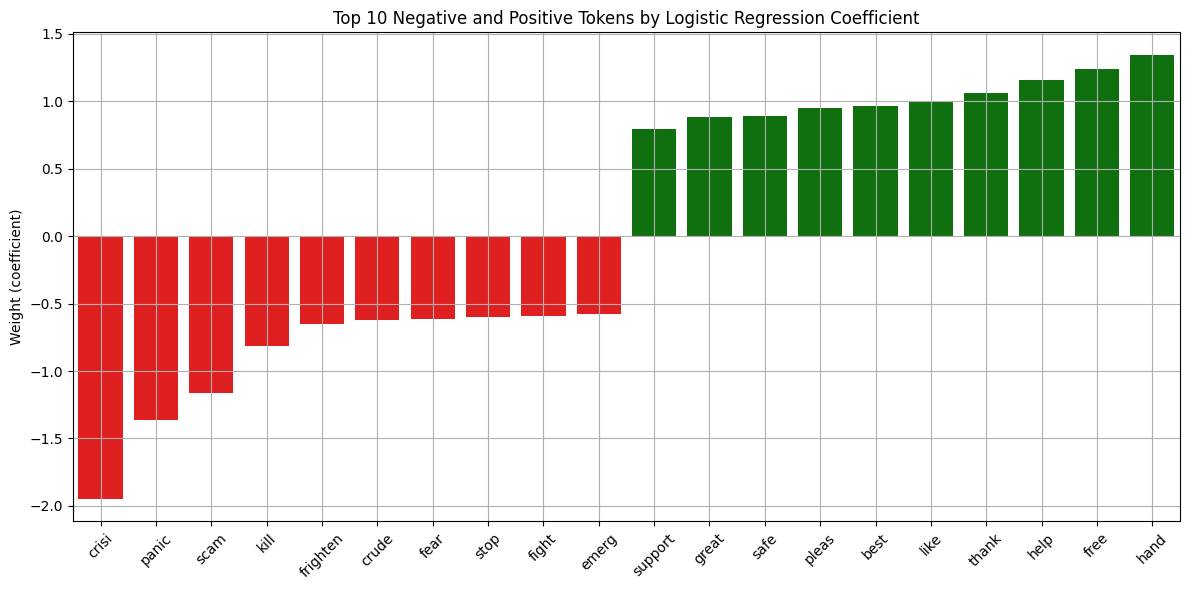

In [218]:
feature_names = np.array(cv_df.get_feature_names_out())
coef = lr_scaled.coef_.flatten()

top_pos_indices = np.argsort(coef)[-10:]
top_neg_indices = np.argsort(coef)[:10]

top_tokens = np.concatenate([feature_names[top_neg_indices], feature_names[top_pos_indices]])
top_weights = np.concatenate([coef[top_neg_indices], coef[top_pos_indices]])

plt.figure(figsize=(12, 6))
sns.barplot(x=top_tokens, y=top_weights, palette=["red"]*10 + ["green"]*10)
plt.title("Top 10 Negative and Positive Tokens by Logistic Regression Coefficient")
plt.xticks(rotation=45)
plt.ylabel("Weight (coefficient)")
plt.grid(True)
plt.tight_layout()
plt.show()

Сами токены (слова) довольно логично вписываются в контекст соответствующего сентимента, например для негативных (kill, scam, panic, etc.). Качество с заскейленными признаками немного падает на трейне и на тесте

#### Шаг 7. Другие признаки

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучим признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируем их, добавив к матрице с отскалированными признаками, обучим логистическую регрессию, замерим качество.

In [219]:
df.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Sentiment_binary
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,1
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,1
2,3802,48754,Unknown,16-03-2020,My food stock is not the only one which is emp...,Positive,1


In [220]:
print('UserName уникальных:', df['UserName'].nunique())
print('ScreenName уникальных:', df['ScreenName'].nunique())
print('Размер датасета:', len(df))

UserName уникальных: 33444
ScreenName уникальных: 33444
Размер датасета: 33444


Все значения уникальны -> неинформативны -> нет смысла кодировать

Изучим признак TweetAt в обучающей выборке: преобразуем его к типу datetime и нарисуем его гистограмму с разделением по цвету на основе целевой переменной. Полезен ли он? Если полезен, то закодируем его, добавим к матрице с отскалированными признаками, обучим логистическую регрессию, замерим качество.

<Figure size 1200x600 with 0 Axes>

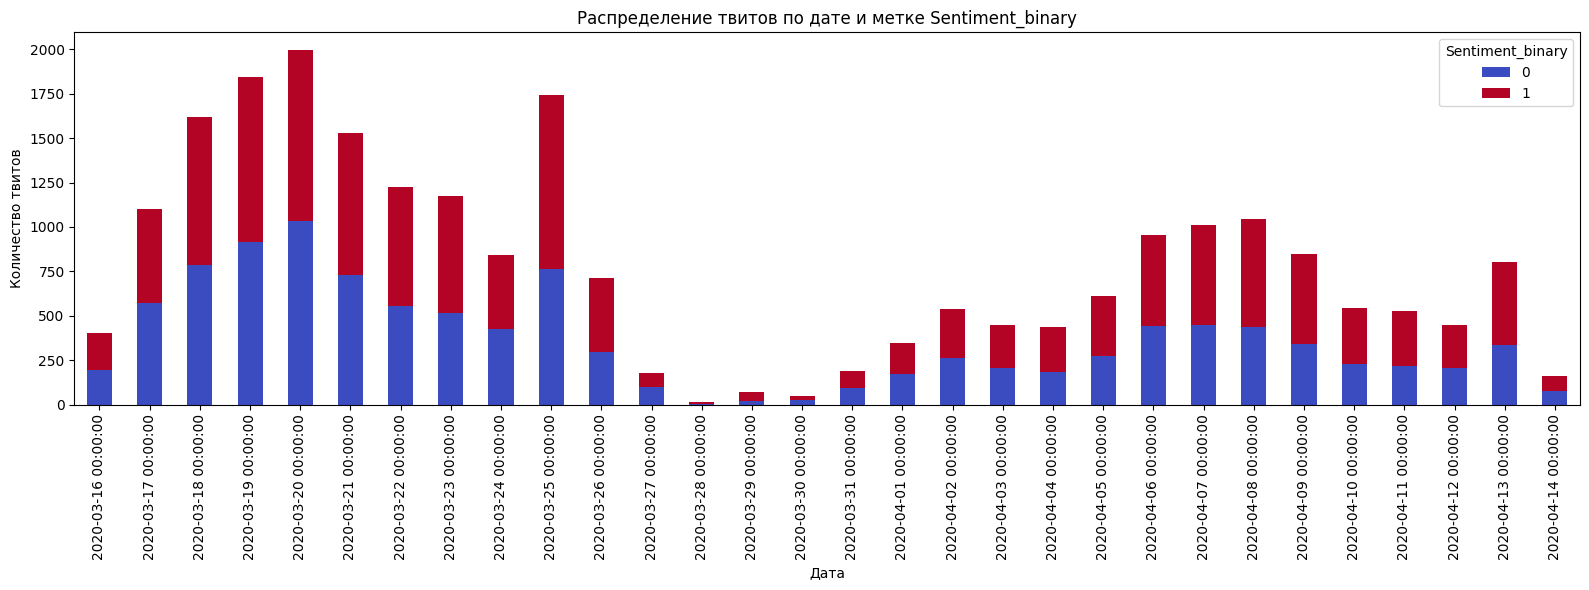

In [221]:
train['TweetAt'] = pd.to_datetime(train['TweetAt'], dayfirst=True)
test['TweetAt'] = pd.to_datetime(test['TweetAt'], dayfirst=True)

plt.figure(figsize=(12, 6))
train.groupby(['TweetAt', 'Sentiment_binary']).size().unstack().plot(kind='bar', stacked=True, figsize=(16, 6), colormap='coolwarm')
plt.title('Распределение твитов по дате и метке Sentiment_binary')
plt.xlabel('Дата')
plt.ylabel('Количество твитов')
plt.tight_layout()
plt.show()

In [222]:
train['date_ord'] = train['TweetAt'].map(lambda x: x.toordinal())
test['date_ord'] = test['TweetAt'].map(lambda x: x.toordinal())

In [224]:
from scipy.sparse import hstack

scaler_date = StandardScaler()
train_date_scaled = scaler_date.fit_transform(train[['date_ord']])
test_date_scaled = scaler_date.transform(test[['date_ord']])

X_train = hstack([vec_train_scaled, train_date_scaled])
X_test = hstack([vec_test_scaled, test_date_scaled])

In [225]:
lr_scaled_wide = LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr')
lr_scaled_wide.fit(X_train, train['Sentiment_binary'])


train_pred_count = lr_scaled_wide.predict(X_train)
test_pred_count = lr_scaled_wide.predict(X_test)
acc_train_count = accuracy_score(train[target], train_pred_count)
acc_test_count = accuracy_score(test[target], test_pred_count)
print(classification_report(test[target], test_pred_count))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      4552
           1       0.86      0.87      0.86      5482

    accuracy                           0.85     10034
   macro avg       0.85      0.85      0.85     10034
weighted avg       0.85      0.85      0.85     10034



In [226]:
print('Train Accuracy:', acc_train_count)
print('Test Accuracy:', acc_test_count)

Train Accuracy: 0.9472020504058095
Test Accuracy: 0.8477177596173012


Качество не сильно изменилось, но это логично, т.к. в целом кол-во позитивных и негативных твитов одинаково сбалансировано почти по всем дням

Посмотрим так же на признак Location

In [227]:
print('Уникальных значений в Location:', train['Location'].nunique())

Уникальных значений в Location: 7949


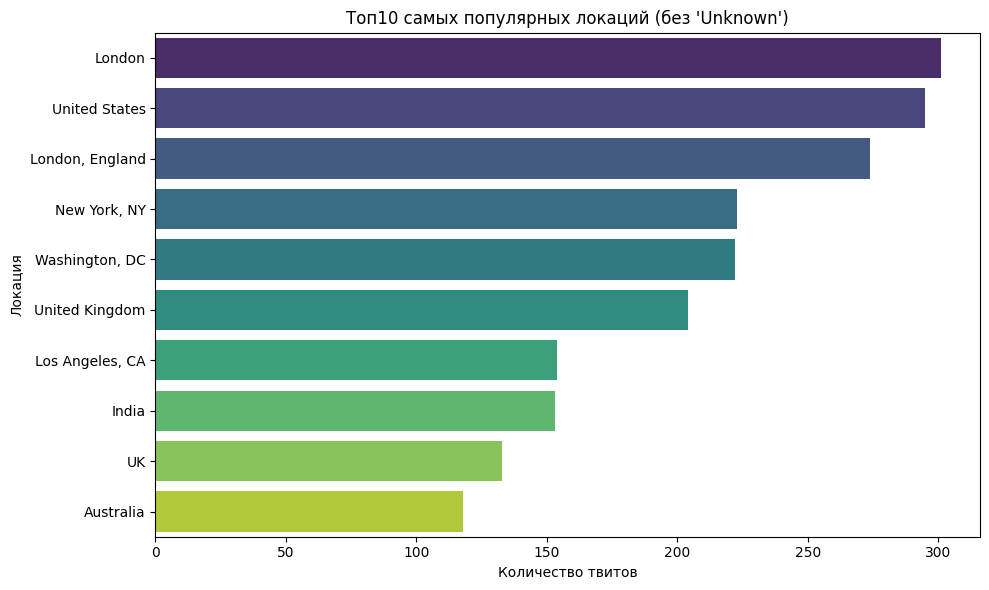

In [228]:
location_counts = train[train['Location'] != 'Unknown']['Location'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=location_counts.values, y=location_counts.index, palette="viridis")
plt.title("Топ10 самых популярных локаций (без 'Unknown')")
plt.xlabel("Количество твитов")
plt.ylabel("Локация")
plt.tight_layout()
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создадим новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Построим аналогичную гистограмму.

In [229]:
train['WiderLocation'] = (train['Location'].fillna('Unknown').apply(lambda x: x.split(',')[-1].strip() if x != 'Unknown' else 'Unknown'))
test['WiderLocation'] = (test['Location'].fillna('Unknown').apply(lambda x: x.split(',')[-1].strip() if x != 'Unknown' else 'Unknown'))

print('Уникальных WiderLocation:', train['WiderLocation'].nunique())

Уникальных WiderLocation: 4631


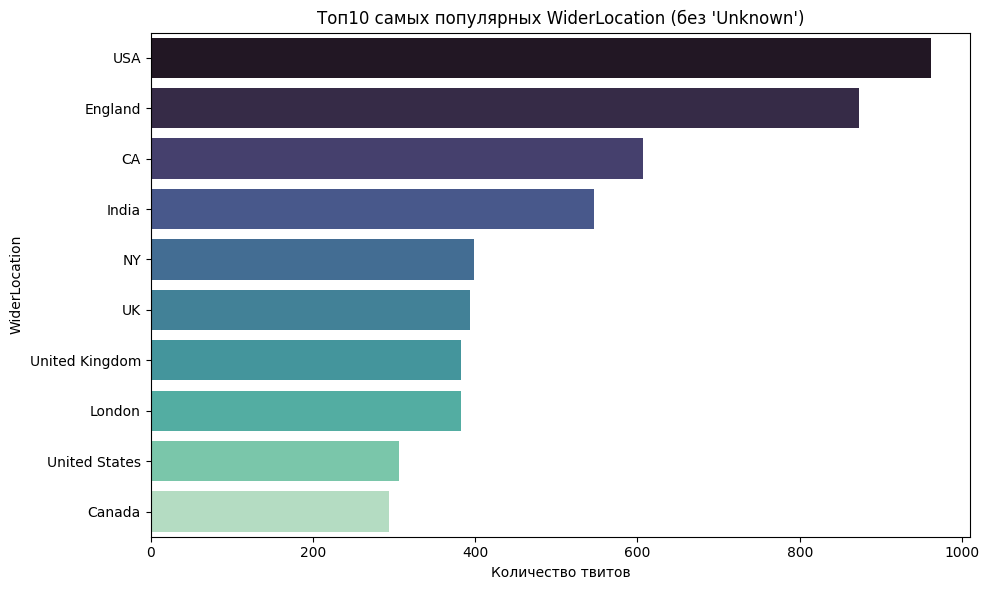

In [ ]:
top_wider_locations = (train[train['WiderLocation'] != 'Unknown']['WiderLocation'].value_counts().head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x=top_wider_locations.values, y=top_wider_locations.index, palette="mako")
plt.title("Топ10 самых популярных WiderLocation (без 'Unknown')")
plt.xlabel("Количество твитов")
plt.ylabel("WiderLocation")
plt.tight_layout()
plt.show()

Закодируем признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [232]:
from sklearn.preprocessing import OneHotEncoder

counts = train['WiderLocation'].value_counts()
frequent_locations = counts[counts > 1].index.tolist()

train['WiderLocation_filtered'] = train['WiderLocation'].where(train['WiderLocation'].isin(frequent_locations))


ohe = OneHotEncoder(handle_unknown='ignore')
wl_ohe = ohe.fit_transform(train[['WiderLocation_filtered']])

print(f'Уникальных WiderLocation с частотой > 1 (OHE): {wl_ohe.shape[1]}')

Уникальных WiderLocation с частотой > 1 (OHE): 989


Добавим этот признак к матрице отскалированных текстовых признаков, обучим логистическую регрессию, замерим качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [233]:
counts = train['WiderLocation'].value_counts()
frequent_locations = counts[counts > 1].index.tolist()

train['WiderLocation_filtered'] = train['WiderLocation'].where(train['WiderLocation'].isin(frequent_locations))
test['WiderLocation_filtered'] = test['WiderLocation'].where(test['WiderLocation'].isin(frequent_locations))

ohe = OneHotEncoder(categories=[frequent_locations], handle_unknown='ignore')

wl_ohe_train = ohe.fit_transform(train[['WiderLocation_filtered']])
wl_ohe_test = ohe.transform(test[['WiderLocation_filtered']])

X_train = hstack([vec_train, wl_ohe_train])
X_test = hstack([vec_test, wl_ohe_test])

lr_wl = LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr')
lr_wl.fit(X_train, train[target])

train_pred = lr_wl.predict(X_train)
test_pred = lr_wl.predict(X_test)

acc_train = accuracy_score(train[target], train_pred)
acc_test = accuracy_score(test[target], test_pred)
print(classification_report(test[target], test_pred_count))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      4552
           1       0.86      0.87      0.86      5482

    accuracy                           0.85     10034
   macro avg       0.85      0.85      0.85     10034
weighted avg       0.85      0.85      0.85     10034



In [234]:
print(f"Train accuracy с WiderLocation OHE: {acc_train}")
print(f"Test accuracy с WiderLocation OHE: {acc_test}")

Train accuracy с WiderLocation OHE: 0.9346860316104229
Test accuracy с WiderLocation OHE: 0.8677496511859677


Качество слегка выросло, это говорит о том, что признак локации добавляет модели обобщающие способности.

**ИТОГ:**

- Мы пошагово организовали пайплайн работы с текстами и решения задачи классификации твитов о коронавирусе на позитивные и негативные. 
- Написали и усовершенствовали собственный токенайзер, добавив в него очистку стоп-слов, спец символов, а так же стемминг.
- Посмотрели на векторизацию с помощью Bag-of-words и TF-IDF
- Посмотрели на качество логистической регресии при различных подходах к токенизации и векторизации, а так же при масштабировании и добавлении дополнительных признаков